In [1]:
import time
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM,BatchNormalization
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import lstm
from sklearn.preprocessing import MinMaxScaler,Normalizer,StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_squared_log_error
from math import sqrt
from keras.callbacks import EarlyStopping, Callback,ModelCheckpoint

C:\Users\ndrs\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def plot_loss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_results(y_true, y_pred):
    mse=mean_squared_error(y_true,y_pred)
    #msle=mean_squared_log_error(y_true,y_pred)
    rmse = sqrt(mean_squared_error(y_true,y_pred))
    r2=r2_score(y_true,y_pred)
    mape=mean_absolute_percentage_error(y_true,y_pred)
    #print('msle',msle)
    print('rmse',rmse)
    print('mse',mse)
    print('mape',mape)
    print('r2',r2)
def plot_results(true_data,predicted_data):
   fig = plt.figure(facecolor='white')
   ax = fig.add_subplot(111)
   ax.plot(true_data, label='True Data')
   ax.plot(predicted_data, label='Predicted Data')
   plt.legend(loc='best')
   plt.show();

def inverse_trans(data,scaler):
    inverted=list()
    for i in range(len(data)):
        forecast=np.array(data[i])
        forecast=forecast.reshape(-1,1)
        inv_scale=scaler.inverse_transform(forecast)
        inv_scale=inv_scale.reshape(-1)
        inverted.append([x for x in inv_scale])
    return inverted
def difference(window_data,lag=1):
    diff=[]
    for i in range(lag,len(window_data)):
        value=window_data[i]-window_data[i-lag]
        diff.append(value)
    return diff

def rescale_windows(window_data):
    #result=difference(window_data)
    result,scaler=scale_windows(window_data)
    #result=norm_windows(window_data)
    #result=log_windows(window_data)
    #result=normalise_windows(window_data)
    #result=standard_windows(window_data)
    return result,scaler

def log_windows(window_data):
    return np.log(window_data)
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) if window[0]!=0 else 0 for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
def scale_windows(window_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(window_data)
    return scaled_values,scaler
def norm_windows(window_data):
    scaler = Normalizer()
    scaled_values = scaler.fit_transform(window_data)
    return scaled_values
def standard_windows(window_data):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(window_data)
    return scaled_values

def load_data(seq_len, normalise_window):
    data_list=['Barclays-Noida-3.2-Jan', 'Barclays-Noida-3.2-Feb', 'Barclays-Noida-3.2-March','Barclays-Noida-3.2-April']

    for month in range(len(data_list)):
        month_data=pickle.load(open('../../processed_data/'+data_list[month]+'.p', "rb" ))
        if month==0:
            data=month_data.copy()
        else:
            data=pd.concat([data,month_data])
    data=data.drop(['Country','Department','Resource Type'],axis=1)

    data=data.groupby([data.floor,data.seatName,pd.Grouper(key='Datetime',freq='H')])
    data=data['Space'].agg([np.sum])
    data.reset_index(inplace=True)
    data['isOccupied']=[0 if x <3 else 1 for x in data['sum']]
    data=data.drop(['sum'],axis=1)
    floor_data=data.groupby([data.floor,pd.Grouper(key='Datetime',freq='D')])['isOccupied'].agg([np.sum])
    floor_data.reset_index(inplace=True)
    one_floor=floor_data.loc[floor_data.floor=='Level 9']
    one_floor.set_index('Datetime',inplace=True)
    one_floor.index.freq='D'
    data=np.array(one_floor['sum'])

    scaler=None
    if normalise_window:
        print('shape prior transformation',data.shape)
        data=data.reshape(-1, 1)
        result,scaler = rescale_windows(data)

    data = np.array(result)

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result=np.array(result)

    row=int(result.shape[0])-7
    #row=int(result.shape[0])-336
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test,scaler]

In [45]:
seq_len=7
pred_len=7
normalize=True
x_train, y_train, x_test, y_test,scaler=load_data(seq_len,normalize)
print(x_train.shape,y_train.shape)
print(x_test.shape)

shape prior transformation (92,)
(77, 7, 1) (77, 1)
(7, 7, 1)


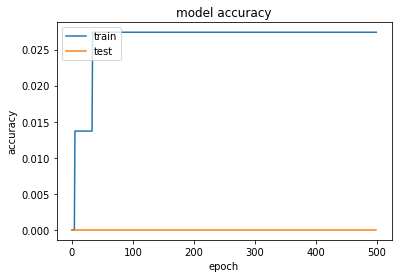

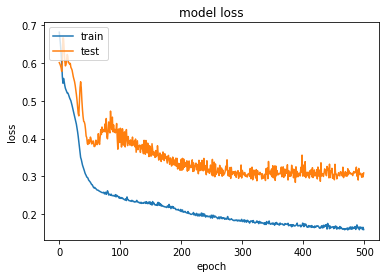

In [48]:
from keras import optimizers
adam=optimizers.Adam(amsgrad=True)

batch_size=20
model=Sequential()
#model.add(LSTM(input_dim=1,output_dim=100,return_sequences=True))
model.add(CuDNNLSTM(units=50,input_shape=(x_train.shape[1],x_train.shape[2])))
#model.add(Dropout(0.1))
model.add(Dense(output_dim=1))
model.add(Activation("linear"))
model.compile(loss='mae',optimizer=adam,metrics=['acc'])

history=model.fit(x_train, y_train,batch_size=batch_size,epochs=500,validation_split=0.05,shuffle=False,verbose=0)
plot_loss(history)

rmse 861.4296138023145
mse 742060.9795356047
mape 29.81907476063081
r2 -0.06576537482309175


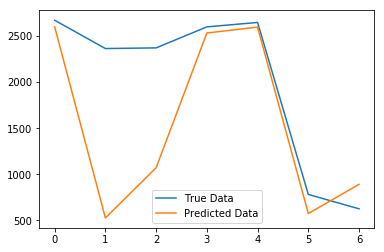

In [49]:
predictions=lstm.predict_sequences_multiple(model,x_test,seq_len,pred_len)
y_t_test=y_test.copy()
normalize=True
if normalize:
    predictions=inverse_trans(predictions,scaler)
    y_t_test=scaler.inverse_transform(y_t_test)
    
pred_data= np.array(predictions)
pred_data=pred_data.reshape(-1,1)
evaluate_results(y_t_test,pred_data)
plot_results(y_t_test,pred_data)
#lstm.plot_results_multiple(predictions,y_t_test,pred_len)

(84,)
(84,)
yo


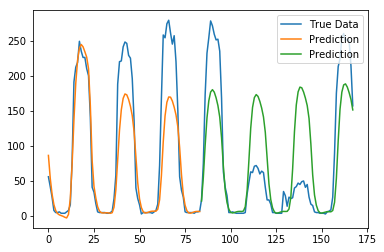

### BENCHMARK RESULT

yo


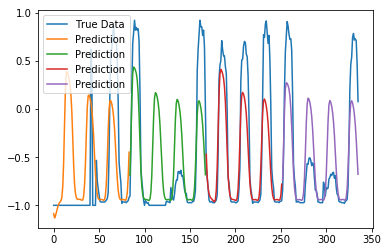

In [128]:
predictions=lstm.predict_sequences_multiple(model,x_test,seq_len,pred_len)
lstm.plot_results_multiple(predictions,y_test,pred_len)